### Fitting OCCAM clusters.


We fit in the latent space whitout any whitening to keep things simple

### Setup

Importing all the required modules

### To-do

* Need to somehow account for missing values in input of spectra during training

* Need to remove outliers before generating the LatentVectorDataset (or be capable of fully deleting them). I don't want for my cluster_centered to be affected by outlier means

* In order to be sure thats its actually a real effect we need to check that were not just observing the effect of averaging latents.

In [4]:
%load_ext autoreload
%autoreload 2

import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

import inspect

from apoNN.src.occam import Occam

import apogee.tools.read as apread
import apogee.tools.path as apogee_path
from apogee.tools import bitmask
import collections


from apoNN.src.datasets import ApogeeDataset
from apoNN.src.utils import generate_loss_with_masking
from apoNN.src.utils import dump
from apoNN.src.utils import load
import apoNN.src.vectors as vector

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
from sklearn.decomposition import PCA


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

apogee_path.change_dr(16)

## Loading datasets


We load all of our different datasets

In [5]:
n_data=2000

In [6]:
autoencoder = torch.load("/share/splinter/ddm/taggingProject/apogeeFactory/outputs/guild/z10/ae_s_8000.p")


### Cleaning

we first create a temporary dataset where we attempt to 

In [7]:
occam = load("occam")
allStar_occam = occam["allStar"]
dataset_occam = ApogeeDataset(allStar_occam,outputs = ["aspcap","mask","physical","idx"])
occam_cluster_idxs = occam["cluster_idxs"]
z_occam = vector.OccamLatentVector(dataset_occam,autoencoder,occam_cluster_idxs,len(dataset_occam))

20.222292
138


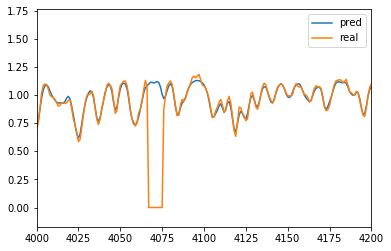

20.639788
143


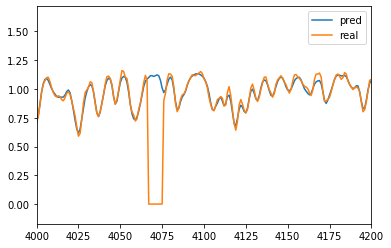

22.74917
145


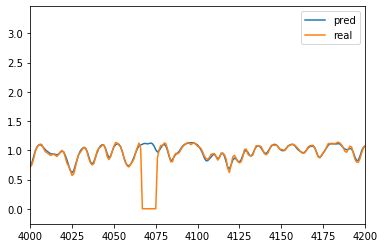

20.349344
148


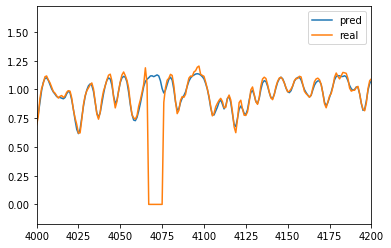

20.799362
151


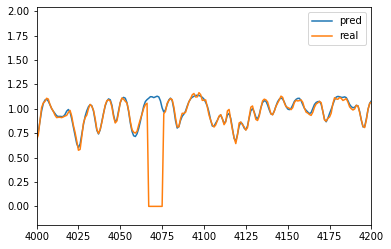

22.88862
161


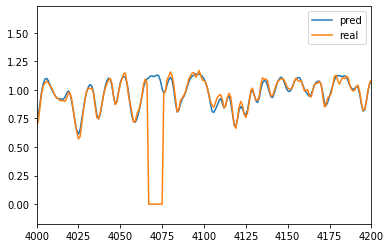

IndexError: index 230 is out of bounds for axis 0 with size 230

In [8]:
bad_indexes = []
for i in range(300):
    err = np.sqrt(np.sum(((z_occam.get_x(i)-z_occam.get_x_pred(i))**2)))
    if err>20:
        print(err)
        print(i)
        bad_indexes.append(i)
        z_occam.plot(i)
        plt.show()


(4000, 4100)

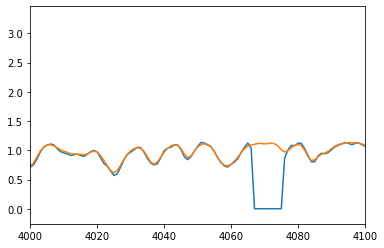

In [9]:
plt.plot(z_occam.get_x(145))
plt.plot(z_occam.get_x_pred(145))
plt.xlim(4000,4100)


In [10]:
len(bad_indexes)

6

In [11]:
occam = load("occam")
allStar_occam = occam["allStar"]
retained = np.delete(np.arange(len(allStar_occam)),bad_indexes)
#len(allStar_occam[retained])
dataset_occam = ApogeeDataset(allStar_occam[retained],outputs = ["aspcap","mask","physical","idx"])
occam_cluster_idxs = occam["cluster_idxs"][retained]
len(occam_cluster_idxs)

224

In [12]:
allStar_behaved_restricted =  load("allStar_behaved_restricted")
dataset_behaved_restricted =  ApogeeDataset(filename="behaved_restricted",outputs = ["aspcap","mask","physical","idx"])

In [13]:
considered_parameters = ["Teff","logg","Fe_H","O_FE","C_FE","Na_FE","Mg_FE","Si_FE","S_FE","Al_FE","P_FE","Ni_FE"] 
y = vector.Vector(np.array([allStar_behaved_restricted[param] for param in considered_parameters])[:,:n_data].T)

### Creating vectors from datasets

In [14]:
z = vector.LatentVector(dataset_behaved_restricted,autoencoder,n_data)

/share/splinter/ddm/taggingProject/apogeeFactory/apoNN/src/vectors.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _,z = self.autoencoder(torch.tensor(self.dataset[idx][0]).to(device).unsqueeze(0))


In [15]:
z_occam = vector.OccamLatentVector(dataset_occam,autoencoder,occam_cluster_idxs,len(dataset_occam))

### Fitting the model

In [16]:
cluster_pca = PCA(n_components=10)

In [17]:
len(z_occam.cluster_centered)

224

In [18]:
cluster_pca.fit(np.delete(z_occam.cluster_centered,bad_indexes,axis=0))

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [19]:
cluster_pca.fit(z_occam.cluster_centered)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [20]:
cluster_pca.fit(z.centered[1000:1200])

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [21]:
cluster_pca.explained_variance_

array([3.7178097 , 1.681179  , 0.8210246 , 0.5449083 , 0.36450508,
       0.24957253, 0.17848341, 0.07737574, 0.03894789, 0.01185859],
      dtype=float32)

In [22]:
cluster_pca.explained_variance_

array([3.7178097 , 1.681179  , 0.8210246 , 0.5449083 , 0.36450508,
       0.24957253, 0.17848341, 0.07737574, 0.03894789, 0.01185859],
      dtype=float32)

### Calculating projections along specific directions

In [23]:
w = vector.LinearTransformation(z,y)
nonlinear_w = vector.NonLinearTransformation(z,y)
nonlinear_w.fit(n_epochs=300)

err:0.11784574389457703
err:0.11116693168878555
err:0.11304187029600143
err:0.10556305199861526
err:0.09888983517885208
err:0.08960043638944626
err:0.07489387691020966
err:0.06726988404989243
err:0.07198601216077805
err:0.07032964378595352
err:0.06506764888763428
err:0.05957101285457611
err:0.06195833906531334
err:0.04555663466453552
err:0.07728216052055359
err:0.05870404094457626
err:0.04385547712445259
err:0.04095332697033882
err:0.033410683274269104
err:0.03998752683401108
err:0.03950659558176994
err:0.04289090633392334
err:0.05267437547445297
err:0.04661207273602486
err:0.038788389414548874
err:0.04245900735259056
err:0.03500613570213318
err:0.03226073831319809
err:0.03530668094754219
err:0.03798236697912216
err:0.03720341995358467
err:0.034036438912153244
err:0.03734191507101059
err:0.0285455621778965
err:0.04787001386284828
err:0.03541427105665207
err:0.028577223420143127
err:0.02611605077981949
err:0.022511275485157967
err:0.027885911986231804
err:0.02923598699271679
err:0.02944

err:0.01645495370030403
err:0.02153351716697216
err:0.023482613265514374
err:0.022155240178108215
err:0.030480671674013138
err:0.029881423339247704
err:0.022670278325676918
err:0.02657441236078739
err:0.021852776408195496
err:0.02346605621278286
err:0.022931529209017754
err:0.02770036831498146
err:0.025198934599757195
err:0.024664834141731262
err:0.027422619983553886
err:0.021222924813628197
err:0.030756181105971336
err:0.023246372118592262
err:0.02165597304701805
err:0.020233983173966408
err:0.01638362929224968
err:0.021459417417645454
err:0.023369252681732178
err:0.022071370854973793
err:0.030325187370181084
err:0.029743799939751625
err:0.0225871242582798
err:0.026442578062415123
err:0.02174471504986286
err:0.023350846022367477
err:0.022797120735049248
err:0.02757800556719303
err:0.025098908692598343
err:0.02455209009349346
err:0.027342678979039192
err:0.021126918494701385
err:0.030587604269385338
err:0.023142997175455093
err:0.021574154496192932
err:0.020136473700404167
err:0.016312

err:0.01868130825459957
err:0.015341805294156075
err:0.020161155611276627
err:0.02158239483833313
err:0.020714858546853065
err:0.027814147993922234
err:0.02770317532122135
err:0.021265020594000816
err:0.02429313026368618
err:0.02020334266126156
err:0.021695252507925034
err:0.020561033859848976
err:0.02550489455461502
err:0.02337745949625969
err:0.02266840636730194
err:0.026025768369436264
err:0.019590504467487335
err:0.02764761447906494
err:0.02148384414613247
err:0.02029861882328987
err:0.01861312799155712
err:0.01529974676668644
err:0.02010190114378929
err:0.02151493728160858
err:0.020664000883698463
err:0.027718951925635338
err:0.027628155425190926
err:0.021214323118329048
err:0.02420102246105671
err:0.02014485001564026
err:0.021634118631482124
err:0.020472167059779167
err:0.025417953729629517
err:0.023306328803300858
err:0.02259296178817749
err:0.02596990577876568
err:0.019530175253748894
err:0.0275185015052557
err:0.02141590043902397
err:0.020249351859092712
err:0.0185516811907291

err:0.025352733209729195
err:0.02028995007276535
err:0.019392207264900208
err:0.017455928027629852
err:0.014658489264547825
err:0.019157903268933296
err:0.020408444106578827
err:0.01970602385699749
err:0.025958359241485596
err:0.0263969786465168
err:0.020377594977617264
err:0.022612638771533966
err:0.019181253388524055
err:0.020741479471325874
err:0.018988346680998802
err:0.023791547864675522
err:0.022027887403964996
err:0.02123452164232731
err:0.025036608800292015
err:0.0184900164604187
err:0.025257078930735588
err:0.020237520337104797
err:0.019352708011865616
err:0.017405729740858078
err:0.01463179662823677
err:0.019118446856737137
err:0.02036060020327568
err:0.019665228202939034
err:0.025883326306939125
err:0.026348691433668137
err:0.020339740440249443
err:0.022548364475369453
err:0.019136536866426468
err:0.02070758491754532
err:0.018925953656435013
err:0.023706723004579544
err:0.02197118289768696
err:0.021176060661673546
err:0.024992549791932106
err:0.01844676211476326
err:0.025161

err:0.0177196953445673
err:0.02352660894393921
err:0.019323870539665222
err:0.01856684871017933
err:0.016441255807876587
err:0.014196912758052349
err:0.01847836747765541
err:0.01957084983587265
err:0.018848542124032974
err:0.02452920563519001
err:0.025410039350390434
err:0.019719334319233894
err:0.021413151174783707
err:0.018333228304982185
err:0.020109815523028374
err:0.017845671623945236
err:0.022352902218699455
err:0.020995603874325752
err:0.02014092728495598
err:0.024187752977013588
err:0.017686406150460243
err:0.023448465391993523
err:0.019280122593045235
err:0.018534207716584206
err:0.016400404274463654
err:0.014176547527313232
err:0.018452193588018417
err:0.01953807659447193
err:0.018808545544743538
err:0.02446640655398369
err:0.025368258357048035
err:0.01969009079039097
err:0.02135949768126011
err:0.018296802416443825
err:0.020083164796233177
err:0.017797835171222687
err:0.02229391783475876
err:0.020953349769115448
err:0.020097384229302406
err:0.024149999022483826
err:0.0176513

err:0.017084188759326935
err:0.022052524611353874
err:0.01850825920701027
err:0.01789800636470318
err:0.015661071985960007
err:0.013851235620677471
err:0.017929881811141968
err:0.018854182213544846
err:0.018112407997250557
err:0.02328217774629593
err:0.024528848007321358
err:0.0191792119294405
err:0.020395899191498756
err:0.01768619567155838
err:0.019566377624869347
err:0.017001338303089142
err:0.02122226357460022
err:0.020181311294436455
err:0.019282808527350426
err:0.023429708555340767
err:0.017058975994586945
err:0.021988337859511375
err:0.018473634496331215
err:0.017867492511868477
err:0.015627583488821983
err:0.013836853206157684
err:0.017904983833432198
err:0.018821431323885918
err:0.018081290647387505
err:0.023231539875268936
err:0.024487769231200218
err:0.019152013584971428
err:0.020350567996501923
err:0.01765807904303074
err:0.01953817345201969
err:0.016964340582489967
err:0.021170029416680336
err:0.020148608833551407
err:0.019247153773903847
err:0.023395519703626633
err:0.017

err:0.02279096655547619
err:0.016643501818180084
err:0.020901381969451904
err:0.01784774474799633
err:0.017324455082416534
err:0.015086342580616474
err:0.01359621249139309
err:0.017462940886616707
err:0.01823081262409687
err:0.01752505637705326
err:0.022321196272969246
err:0.023815922439098358
err:0.01876295544207096
err:0.019541027024388313
err:0.017193717882037163
err:0.01907344162464142
err:0.016361873596906662
err:0.02026749774813652
err:0.019563043490052223
err:0.01861514523625374
err:0.022763164713978767
err:0.016625910997390747
err:0.020853055641055107
err:0.01782027631998062
err:0.017301015555858612
err:0.015065034851431847
err:0.013587519526481628
err:0.01744387298822403
err:0.01820390112698078
err:0.017501097172498703
err:0.02228337898850441
err:0.023786310106515884
err:0.018747661262750626
err:0.019502118229866028
err:0.017174899578094482
err:0.019047686830163002
err:0.016333650797605515
err:0.020231502130627632
err:0.01953755132853985
err:0.01858893223106861
err:0.022737111

err:0.02226746268570423
err:0.016331059858202934
err:0.02003685012459755
err:0.017347557470202446
err:0.01682143658399582
err:0.01464824378490448
err:0.013388624414801598
err:0.017078764736652374
err:0.01769179105758667
err:0.017073284834623337
err:0.021550465375185013
err:0.02325003407895565
err:0.01844318024814129
err:0.018881946802139282
err:0.016818447038531303
err:0.018676310777664185
err:0.015856605023145676
err:0.019529931247234344
err:0.019049225375056267
err:0.01811164990067482
err:0.022246424108743668
err:0.016314484179019928
err:0.019993990659713745
err:0.017326902598142624
err:0.01680075190961361
err:0.014633255079388618
err:0.013381772674620152
err:0.017059795558452606
err:0.017666257917881012
err:0.017051713541150093
err:0.021520068868994713
err:0.023219021037220955
err:0.018433263525366783
err:0.018854904919862747
err:0.01680651865899563
err:0.018658101558685303
err:0.015835940837860107
err:0.019502783194184303
err:0.019029442220926285
err:0.01809030957520008
err:0.02222

err:0.021830057725310326
err:0.016076412051916122
err:0.01933913677930832
err:0.01696993224322796
err:0.01639687828719616
err:0.014288867823779583
err:0.013203230686485767
err:0.01672724448144436
err:0.017220327630639076
err:0.016696618869900703
err:0.020941389724612236
err:0.02276129461824894
err:0.018163099884986877
err:0.018368259072303772
err:0.016511643305420876
err:0.018386922776699066
err:0.01542108878493309
err:0.018933989107608795
err:0.018603358417749405
err:0.01771780103445053
err:0.02181130088865757
err:0.01606687903404236
err:0.01930907927453518
err:0.01695374585688114
err:0.01637936756014824
err:0.014275046065449715
err:0.013193482533097267
err:0.016710659489035606
err:0.01719844527542591
err:0.01668027974665165
err:0.020912373438477516
err:0.022740041837096214
err:0.01815023086965084
err:0.018345341086387634
err:0.016499213874340057
err:0.018370559439063072
err:0.015405273996293545
err:0.018911825492978096
err:0.018586356192827225
err:0.017702776938676834
err:0.021789919

err:0.018243419006466866
err:0.017425566911697388
err:0.021421702578663826
err:0.01584368571639061
err:0.018782656639814377
err:0.01667769066989422
err:0.016006479039788246
err:0.013998327776789665
err:0.013026388362050056
err:0.016403427347540855
err:0.016819018870592117
err:0.016396602615714073
err:0.020460214465856552
err:0.022327657788991928
err:0.017916426062583923
err:0.01794610545039177
err:0.016257163137197495
err:0.018129190430045128
err:0.015019861049950123
err:0.018454192206263542
err:0.018227146938443184
err:0.017410652711987495
err:0.02140292525291443
err:0.015832388773560524
err:0.018762776628136635
err:0.016665715724229813
err:0.015994232147932053
err:0.013988045044243336
err:0.01301913894712925
err:0.01638977974653244
err:0.016802897676825523
err:0.016382340341806412
err:0.020442791283130646
err:0.02230757102370262
err:0.017904940992593765
err:0.017922714352607727
err:0.01624605618417263
err:0.018118849024176598
err:0.015007569454610348
err:0.01843314804136753
err:0.018

err:0.017913615331053734
err:0.017157305032014847
err:0.021060409024357796
err:0.015625495463609695
err:0.01831730641424656
err:0.01641182042658329
err:0.015678146854043007
err:0.013754034414887428
err:0.01283697597682476
err:0.016112394630908966
err:0.016489677131175995
err:0.01613890938460827
err:0.020072557032108307
err:0.021966001018881798
err:0.01767740584909916
err:0.017579862847924232
err:0.016038719564676285
err:0.017906831577420235
err:0.014673776924610138
err:0.018058734014630318
err:0.017901364713907242
err:0.017141995951533318
err:0.0210430845618248
err:0.015617826022207737
err:0.018296074122190475
err:0.01640070416033268
err:0.01566207781434059
err:0.01373936329036951
err:0.01282737497240305
err:0.016098789870738983
err:0.016478393226861954
err:0.016127347946166992
err:0.020054012537002563
err:0.02195136249065399
err:0.0176645889878273
err:0.017559710890054703
err:0.016029058024287224
err:0.017897017300128937
err:0.014657426625490189
err:0.01804126240313053
err:0.017885414

err:0.017632409930229187
err:0.016920099034905434
err:0.020756876096129417
err:0.015428220853209496
err:0.017905648797750473
err:0.01617935113608837
err:0.015394624322652817
err:0.013530458323657513
err:0.012648561969399452
err:0.015851955860853195
err:0.016205035150051117
err:0.015892185270786285
err:0.019718969240784645
err:0.02166365273296833
err:0.017477741464972496
err:0.017262127250432968
err:0.015858592465519905
err:0.017699038609862328
err:0.014381729997694492
err:0.017732245847582817
err:0.017621949315071106
err:0.01690707542002201
err:0.020743226632475853
err:0.015420119278132915
err:0.017892075702548027
err:0.01617148146033287
err:0.015384531579911709
err:0.013522370718419552
err:0.012637774460017681
err:0.015838589519262314
err:0.016190998256206512
err:0.015882955864071846
err:0.01970227062702179
err:0.021647941321134567
err:0.017464973032474518
err:0.0172477625310421
err:0.015853460878133774
err:0.01769125461578369
err:0.014367113821208477
err:0.017718125134706497
err:0.01

err:0.014123007655143738
err:0.017454199492931366
err:0.017370745539665222
err:0.016708040609955788
err:0.020474176853895187
err:0.015257716178894043
err:0.01754896156489849
err:0.015966158360242844
err:0.015162843279540539
err:0.013340799137949944
err:0.012481658719480038
err:0.01561010256409645
err:0.015950607135891914
err:0.015657640993595123
err:0.019428938627243042
err:0.021388588473200798
err:0.017277497798204422
err:0.016979681327939034
err:0.015688540413975716
err:0.0174992885440588
err:0.014111961238086224
err:0.01744244247674942
err:0.017357943579554558
err:0.01669790968298912
err:0.02046157419681549
err:0.015248823910951614
err:0.01753304898738861
err:0.015958227217197418
err:0.015153277665376663
err:0.013333217240869999
err:0.01247590035200119
err:0.015600073151290417
err:0.015939634293317795
err:0.01564766839146614
err:0.01941399648785591
err:0.021372636780142784
err:0.01726362109184265
err:0.016965892165899277
err:0.015683257952332497
err:0.01749008148908615
err:0.0141016

err:0.013889382593333721
err:0.017183886840939522
err:0.017143715173006058
err:0.01651919074356556
err:0.020223669707775116
err:0.015099173411726952
err:0.017224883660674095
err:0.015751099213957787
err:0.014960209839046001
err:0.013165147975087166
err:0.012347438372671604
err:0.015409572049975395
err:0.015732062980532646
err:0.01544814184308052
err:0.019165892153978348
err:0.021132009103894234
err:0.01708586886525154
err:0.01671820878982544
err:0.01551453024148941
err:0.017284134402871132
err:0.013879436068236828
err:0.017170438542962074
err:0.017131054773926735
err:0.0165095254778862
err:0.02021198719739914
err:0.01509041991084814
err:0.01721031218767166
err:0.01574149914085865
err:0.014950677752494812
err:0.013154353015124798
err:0.012341133318841457
err:0.015400009229779243
err:0.01572340354323387
err:0.015441808849573135
err:0.019154224544763565
err:0.021117443218827248
err:0.0170770101249218
err:0.016709458082914352
err:0.015506120398640633
err:0.017276862636208534
err:0.01386687

err:0.013665405102074146
err:0.01692509651184082
err:0.01692720502614975
err:0.01633523404598236
err:0.020003294572234154
err:0.014943599700927734
err:0.016915947198867798
err:0.015563413500785828
err:0.014764029532670975
err:0.013015368953347206
err:0.012213172391057014
err:0.015216163359582424
err:0.015525897964835167
err:0.015260007232427597
err:0.018925946205854416
err:0.020893661305308342
err:0.016906702890992165
err:0.016490183770656586
err:0.015347919426858425
err:0.017108246684074402
err:0.013656842522323132
err:0.01691213622689247
err:0.016919761896133423
err:0.016327660530805588
err:0.019993465393781662
err:0.014933866448700428
err:0.0169032234698534
err:0.0155536700040102
err:0.014755547977983952
err:0.013009568676352501
err:0.012207014486193657
err:0.015209323726594448
err:0.015513820573687553
err:0.015251840464770794
err:0.018915265798568726
err:0.02087913639843464
err:0.016901426017284393
err:0.016481103375554085
err:0.015340430662035942
err:0.017100656405091286
err:0.013

Text(0.5, 1.0, 'Fe_H')

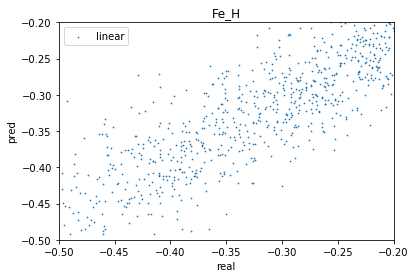

In [59]:
i=2
plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.5,label="linear")
plt.xlim(-0.5,-0.2)
plt.ylim(-0.5,-0.2)
plt.legend()
plt.xlabel("real")
plt.ylabel("pred")
plt.title(considered_parameters[i])

In [25]:
normed_w = w.val/np.linalg.norm(w.val,axis=1)[:,None]

In [26]:
vector.get_vars(z.centered,normed_w)

array([0.3809011 , 0.3850816 , 0.4733449 , 0.38553765, 0.19097668,
       0.21038136, 0.31247228, 0.31944716, 0.36688873, 0.2805095 ,
       0.5721134 , 0.3098996 ], dtype=float32)

In [27]:
vector.get_vars(z_occam.cluster_centered,normed_w)

array([0.62234616, 0.47146334, 0.11743261, 0.23318543, 0.09483912,
       0.10357309, 0.2306916 , 0.17150873, 0.22709358, 0.0825881 ,
       0.45418121, 0.1751873 ])

(array([  4.,  17.,  58., 101., 150., 227., 351., 683., 372.,  37.]),
 array([-2.4919562 , -2.1194038 , -1.7468513 , -1.3742989 , -1.0017465 ,
        -0.6291941 , -0.25664166,  0.11591078,  0.48846322,  0.8610156 ,
         1.2335681 ], dtype=float32),
 <a list of 10 Patch objects>)

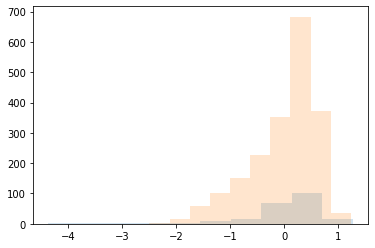

In [47]:
idx = 0
plt.hist(vector.project(z_occam.cluster_centered,normed_w)[idx],alpha=0.2)
plt.hist(vector.project(z.centered,normed_w)[idx],alpha=0.2)

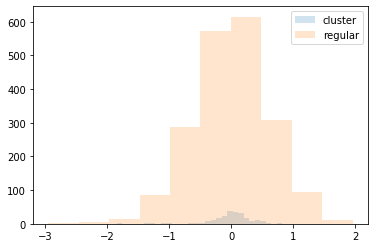

In [29]:
i=9
plt.hist(z_occam.cluster_centered[:,i],label="cluster",alpha=0.2,bins=30)
plt.hist(z.centered[:,i],label="regular",alpha=0.2)
plt.legend()

### Investigating individual clusters

In [30]:
clust_idxs =z_occam.registry["NGC 6791"]

In [31]:
z_occam.registry

{'Berkeley 91': array([26]),
 'Berkeley 71': array([25]),
 'NGC 6811': array([168]),
 'NGC 2324': array([95, 96]),
 'NGC 2204': array([75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86]),
 'Basel 11b': array([0]),
 'NGC 1245': array([46]),
 'NGC 2243': array([87, 88, 89, 90, 91]),
 'NGC 2682': array([108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
        121]),
 'Berkeley 31': array([14]),
 'Ruprecht 147': array([214]),
 'NGC 1798': array([47, 48, 49, 50, 51, 52]),
 'NGC 6705': array([128, 129, 130, 131, 132, 133]),
 'Berkeley 33': array([15]),
 'NGC 2304': array([92, 93, 94]),
 'Ruprecht 96': array([215]),
 'Berkeley 53': array([18, 19, 20, 21]),
 'Berkeley 20': array([11, 12]),
 'NGC 2158': array([67, 68, 69, 70, 71, 72, 73, 74]),
 'Teutsch 84': array([216]),
 'Berkeley 98': array([27, 28, 29, 30]),
 'NGC 6819': array([169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
        182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
        195, 1

Text(0.5, 1.0, 'Fe_H')

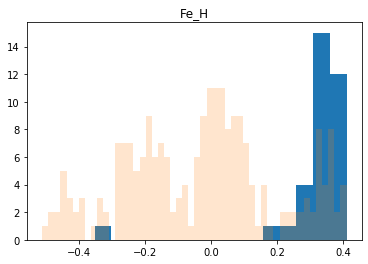

In [60]:
i=2
elem = considered_parameters[i]
plt.hist(z_occam.dataset.allStar[clust_idxs][elem],bins=15)
plt.hist(z_occam.dataset.allStar[elem],bins=50,alpha=0.2)
plt.title(elem)
#plt.xlim(-1,1)

Text(0.5, 1.0, 'Fe_H')

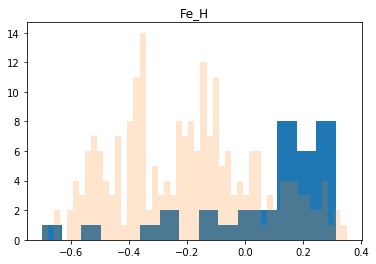

In [61]:
plt.hist(w.predict(z_occam).raw[:,i][clust_idxs],bins=15)
plt.hist(w.predict(z_occam).raw[:,i],bins=50,alpha=0.2)
#plt.hist(vector.project(z_occam.centered,w.val)[i],bins=50,alpha=0.2)

#plt.xlim(-1,1)
plt.title(considered_parameters[i])

Text(0.5, 1.0, 'Si_FE')

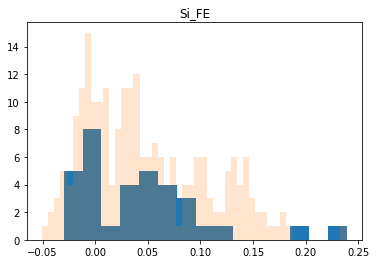

In [34]:
plt.hist(nonlinear_w.predict(z_occam).raw[:,i][clust_idxs],bins=15)
plt.hist(nonlinear_w.predict(z_occam).raw[:,i],bins=50,alpha=0.2)
#plt.hist(vector.project(z_occam.centered,w.val)[i],bins=50,alpha=0.2)

#plt.xlim(-1,1)
plt.title(considered_parameters[i])

(array([ 3.,  0.,  1.,  0.,  1.,  0.,  6.,  5.,  5.,  6., 13.,  6., 12.,
         6., 10., 13., 13.,  6., 18.,  8.,  8.,  9., 11., 11.,  2., 10.,
         6.,  9.,  7.,  5.,  4.,  4.,  2.,  0.,  1.,  0.,  0.,  0.,  1.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-0.11816344, -0.11182577, -0.10548811, -0.09915045, -0.09281279,
        -0.08647513, -0.08013747, -0.0737998 , -0.06746215, -0.06112448,
        -0.05478682, -0.04844916, -0.0421115 , -0.03577383, -0.02943617,
        -0.02309851, -0.01676085, -0.01042319, -0.00408553,  0.00225214,
         0.0085898 ,  0.01492746,  0.02126512,  0.02760278,  0.03394045,
         0.04027811,  0.04661577,  0.05295343,  0.05929109,  0.06562875,
         0.07196642,  0.07830407,  0.08464174,  0.0909794 ,  0.09731706,
         0.10365473,  0.10999238,  0.11633005,  0.12266771,  0.12900537,
         0.13534303,  0.14168069,  0.14801836,  0.15435602,  0.16069368,
         0.16703135,  0.173369  ,  0.17970666,  0.18604432,

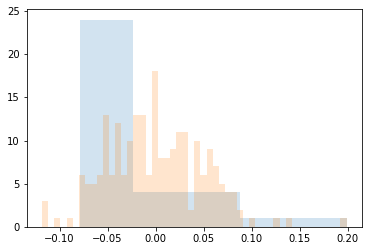

In [35]:
plt.hist(vector.project(z_occam.centered[clust_idxs],w.val)[i],bins=5,alpha=0.2)
plt.hist(vector.project(z_occam.centered,w.val)[i],bins=50,alpha=0.2)

(array([ 3.,  0.,  1.,  0.,  1.,  0.,  6.,  5.,  5.,  6., 13.,  6., 12.,
         6., 10., 13., 13.,  6., 18.,  8.,  8.,  9., 11., 11.,  2., 10.,
         6.,  9.,  7.,  5.,  4.,  4.,  2.,  0.,  1.,  0.,  0.,  0.,  1.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-0.11816344, -0.11182577, -0.10548811, -0.09915045, -0.09281279,
        -0.08647513, -0.08013747, -0.0737998 , -0.06746215, -0.06112448,
        -0.05478682, -0.04844916, -0.0421115 , -0.03577383, -0.02943617,
        -0.02309851, -0.01676085, -0.01042319, -0.00408553,  0.00225214,
         0.0085898 ,  0.01492746,  0.02126512,  0.02760278,  0.03394045,
         0.04027811,  0.04661577,  0.05295343,  0.05929109,  0.06562875,
         0.07196642,  0.07830407,  0.08464174,  0.0909794 ,  0.09731706,
         0.10365473,  0.10999238,  0.11633005,  0.12266771,  0.12900537,
         0.13534303,  0.14168069,  0.14801836,  0.15435602,  0.16069368,
         0.16703135,  0.173369  ,  0.17970666,  0.18604432,

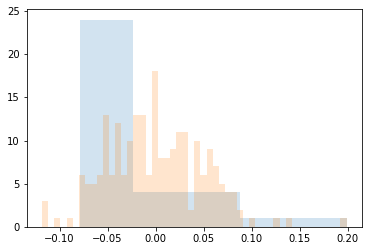

In [36]:
plt.hist(vector.project(z_occam.centered[clust_idxs],w.val)[i],bins=5,alpha=0.2)
plt.hist(vector.project(z_occam.centered,w.val)[i],bins=50,alpha=0.2)

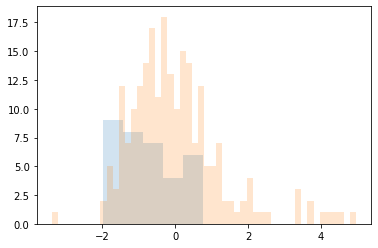

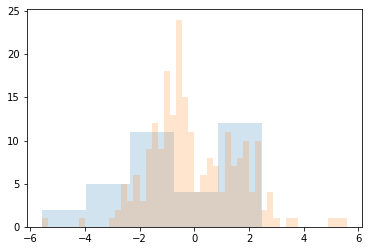

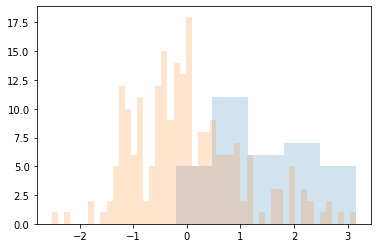

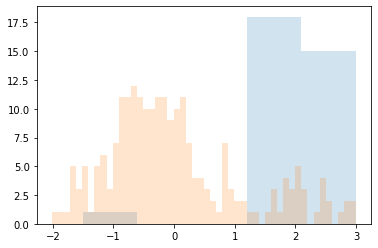

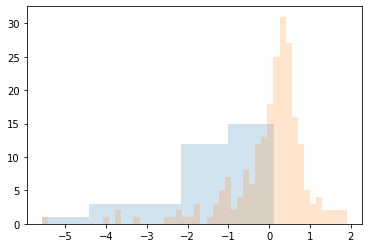

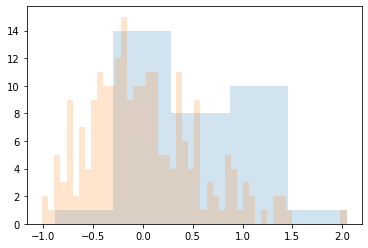

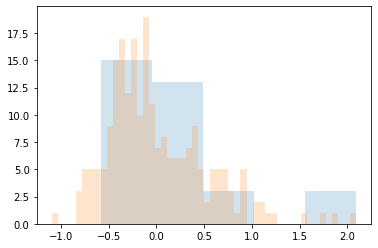

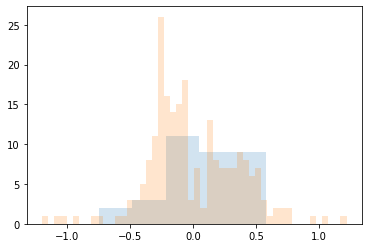

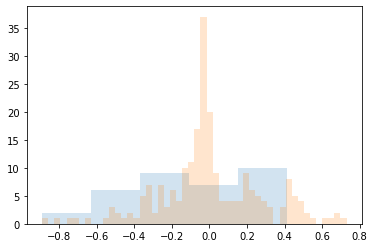

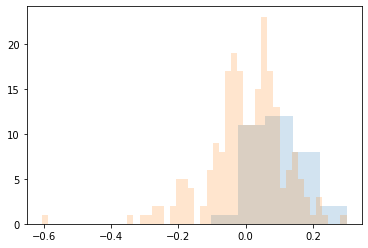

In [37]:
for i in range(10):
    plt.hist(vector.project(z_occam.centered[clust_idxs],cluster_pca.components_)[i],bins=5,alpha=0.2)
    plt.hist(vector.project(z_occam.centered,cluster_pca.components_)[i],bins=50,alpha=0.2)
    plt.show()

In [38]:
cluster_pca.components_

array([[-0.05213236,  0.3214109 ,  0.06227727, -0.63293093, -0.13491942,
         0.66516167,  0.09600163,  0.00842559, -0.09848449,  0.09933487],
       [ 0.22417046, -0.01773036,  0.20344633,  0.17691213,  0.263881  ,
         0.23595749, -0.05509654, -0.8400865 , -0.18014805, -0.10100321],
       [ 0.1838709 ,  0.10360451,  0.68196744,  0.00441348, -0.47659212,
        -0.16292801, -0.14440557, -0.08325087,  0.34759998,  0.29675537],
       [ 0.01136093,  0.02694151, -0.2710849 ,  0.6366307 , -0.31175584,
         0.5027659 ,  0.23210163,  0.02726522,  0.1685373 ,  0.29559135],
       [-0.27084   ,  0.42961654,  0.0200455 ,  0.09697467, -0.24250415,
        -0.35609868,  0.34823215, -0.15243214, -0.59764344,  0.21207504],
       [ 0.23677927,  0.32067996, -0.4977506 , -0.20203246, -0.30532604,
        -0.25701296,  0.14405671, -0.34334183,  0.4267161 , -0.26930416],
       [-0.22985396,  0.03913803,  0.25171927,  0.20467585, -0.36552358,
         0.16793582, -0.0192469 ,  0.09482608

In [39]:
vector.project(z_occam.raw,)
#plt.hist(w.predict(z_occam).raw[:,i][clust_idxs],bins=5)
plt.hist(w.predict(z_occam).raw[:,i],bins=50,alpha=0.2)
#plt.xlim(-1,1)
plt.title(considered_parameters[i])

TypeError: project() missing 1 required positional argument: 'direction'

In [ ]:
plt.hist(vector.project(z_occam.centered,normed_w)[i],alpha=0.2)

(array([ 1.,  9., 24., 72., 46., 40., 19., 10.,  4.,  5.]),
 array([ 6.0473213,  6.71909  ,  7.3908587,  8.062627 ,  8.734396 ,
         9.406164 , 10.077932 , 10.7497015, 11.42147  , 12.093239 ,
        12.765007 ], dtype=float32),
 <a list of 10 Patch objects>)

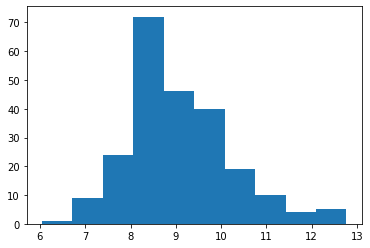

In [147]:
plt.hist(z_occam.raw[:,5])

In [146]:
z_occam.raw[:,0]

array([5.9618692, 5.753513 , 5.990732 , 6.121794 , 5.693242 , 6.02406  ,
       6.2178097, 6.033383 , 6.0738096, 5.9916725, 6.295659 , 5.697259 ,
       5.8560505, 6.4131026, 6.299101 , 6.3736186, 6.9661384, 6.7452025,
       6.500203 , 7.3127637, 6.937939 , 6.5417295, 5.431569 , 5.1409287,
       5.846984 , 6.3837094, 5.7578015, 5.6904864, 5.728746 , 5.81843  ,
       5.9035516, 6.260753 , 6.102787 , 5.791691 , 5.7562647, 5.7683754,
       6.0278697, 6.262476 , 6.817625 , 6.511759 , 6.3301888, 6.726308 ,
       6.504685 , 6.396357 , 5.8023996, 5.7444286, 6.130333 , 6.849437 ,
       6.9235816, 6.0204444, 6.545264 , 6.526266 , 6.5689197, 6.1072817,
       6.035056 , 6.0974445, 6.2467966, 5.891329 , 5.9081697, 5.9575043,
       5.973347 , 6.104736 , 6.0577655, 6.056999 , 6.0887265, 7.05531  ,
       6.088828 , 6.0773683, 5.9903355, 6.2094336, 5.957015 , 6.2550707,
       6.3078895, 6.004138 , 6.2106524, 5.373906 , 5.915272 , 6.233473 ,
       6.0117617, 5.8764477, 6.4989276, 6.1632676, 

In [ ]:
plt.hist(w.predict(z_occam).raw[:,i][clust_idxs],bins=5)
plt.hist(w.predict(z_occam).raw[:,i],bins=50,alpha=0.2)
#plt.xlim(-1,1)
plt.title(considered_parameters[i])